In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
%matplotlib inline
# Retina 
%config InlineBackend.figure_format = 'retina'

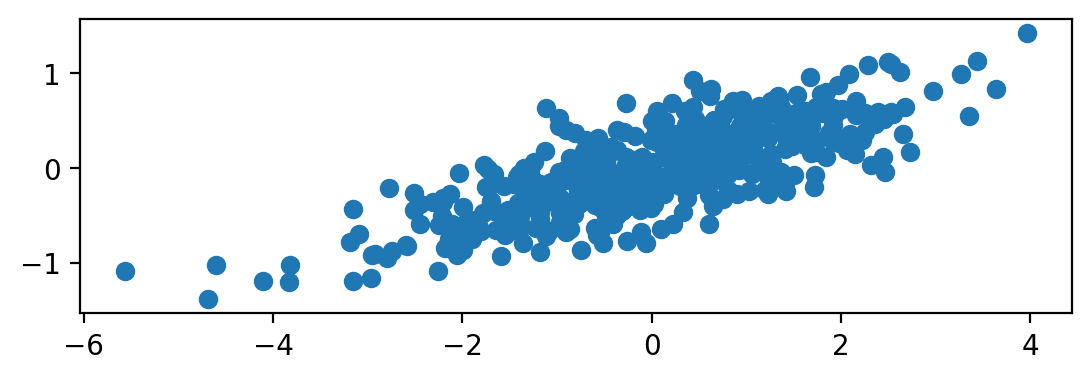

In [85]:
N = 500
D = 2

torch.manual_seed(1)
X = torch.distributions.MultivariateNormal(torch.zeros(D), torch.tensor([[2.0, 0.5], [0.5, 0.2]])).sample((N,))

X = X - X.mean(dim=0)
plt.scatter(X[:,0], X[:,1])
plt.gca().set_aspect('equal', adjustable='box')

In [86]:
covariance_matrix = torch.matmul(X.t(), X) / (X.size(0)-1)
covariance_matrix.shape

torch.Size([2, 2])

In [87]:
covariance_matrix

tensor([[1.9740, 0.5022],
        [0.5022, 0.2127]])

In [88]:
eigenvalues, eigenvectors = torch.linalg.eig(covariance_matrix)

In [89]:
eigenvalues = eigenvalues.real
eigenvalues

tensor([2.1071, 0.0796])

In [90]:
eigenvectors = eigenvectors.real
eigenvectors

tensor([[ 0.9666, -0.2562],
        [ 0.2562,  0.9666]])

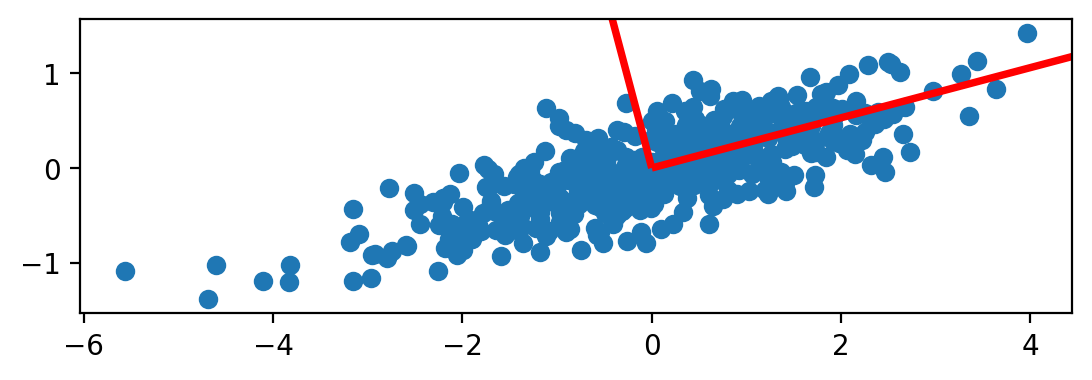

In [91]:
# Plot the eigenvectors along with length of eigenvalues
plt.scatter(X[:,0], X[:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.quiver(0, 0, eigenvectors[0, 0], eigenvectors[1, 0], scale=eigenvalues[0].sqrt().item(), color='red')
plt.quiver(0, 0, eigenvectors[0, 1], eigenvectors[1, 1], scale=eigenvalues[1].sqrt().item(), color='red')


In [84]:
X.mean(dim=0), X.var(dim=0)

(tensor([-4.7684e-09,  0.0000e+00]), tensor([2.0527, 0.2216]))

In [19]:
k = 1  # Number of principal components
B = nn.Parameter(torch.randn(D, k))

In [20]:
B.shape, X.shape

(torch.Size([2, 1]), torch.Size([200, 2]))

In [22]:
mse_loss = nn.MSELoss()

optimizer = optim.Adam([B], lr=0.01) 
num_epochs = 1000  # Number of optimization epochs

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Project data onto the current projection matrix
    z = torch.matmul(X, B)
    x_reconstructed = torch.matmul(z, B.t())
    
    # Compute reconstruction loss
    loss = mse_loss(x_reconstructed, X)
    
    # Perform backpropagation and optimization step
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


Epoch [100/1000], Loss: 0.4095216393470764
Epoch [200/1000], Loss: 0.3843594789505005
Epoch [300/1000], Loss: 0.3837571442127228
Epoch [400/1000], Loss: 0.3837553858757019
Epoch [500/1000], Loss: 0.3837553858757019
Epoch [600/1000], Loss: 0.3837553858757019
Epoch [700/1000], Loss: 0.3837553858757019
Epoch [800/1000], Loss: 0.3837553858757019
Epoch [900/1000], Loss: 0.3837553858757019
Epoch [1000/1000], Loss: 0.3837553858757019


In [23]:
# Project data onto the learned projection matrix
Z = torch.matmul(X, B)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

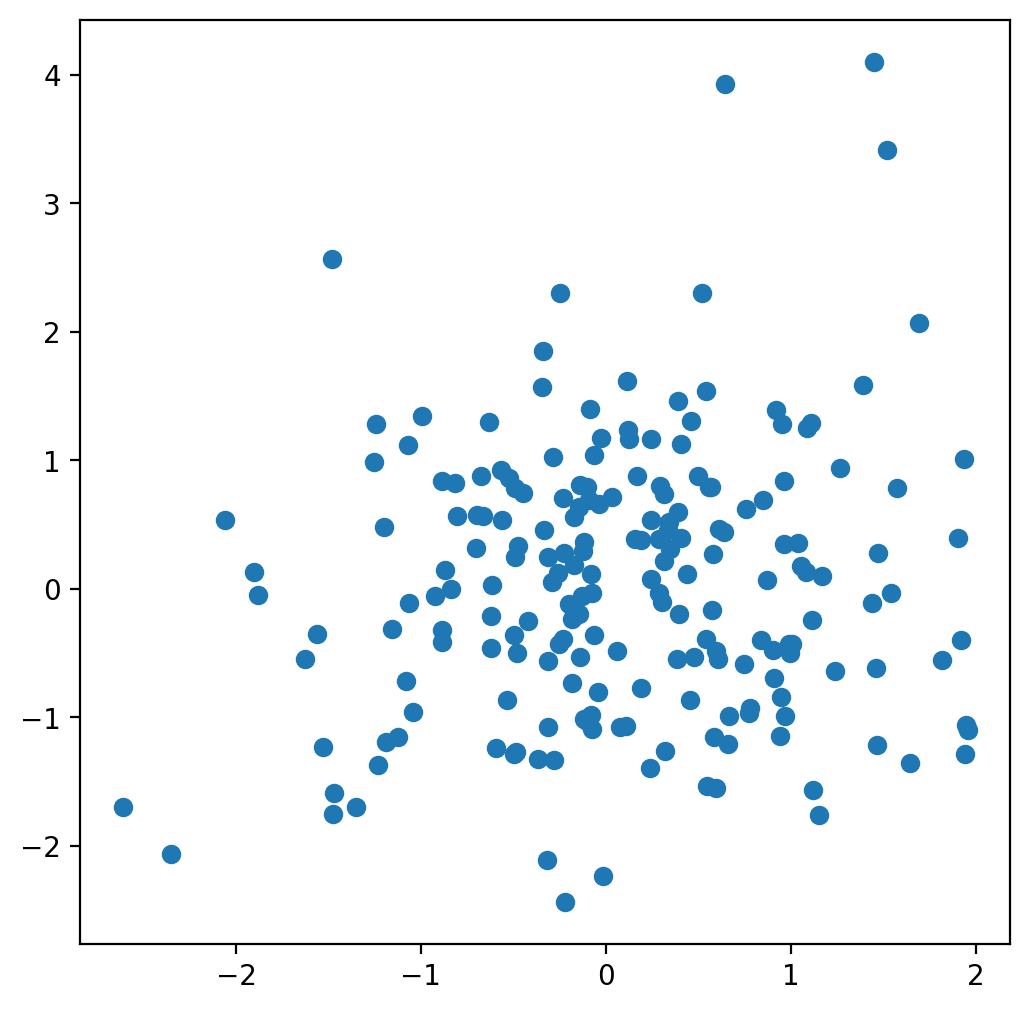

In [25]:
# Plot the original data and the projected data
plt.figure(figsize=(6, 6))
plt.scatter(X[:,0], X[:,1], label='Original data')
plt.scatter(Z[:,0], Z[:,0], label='Projected data')

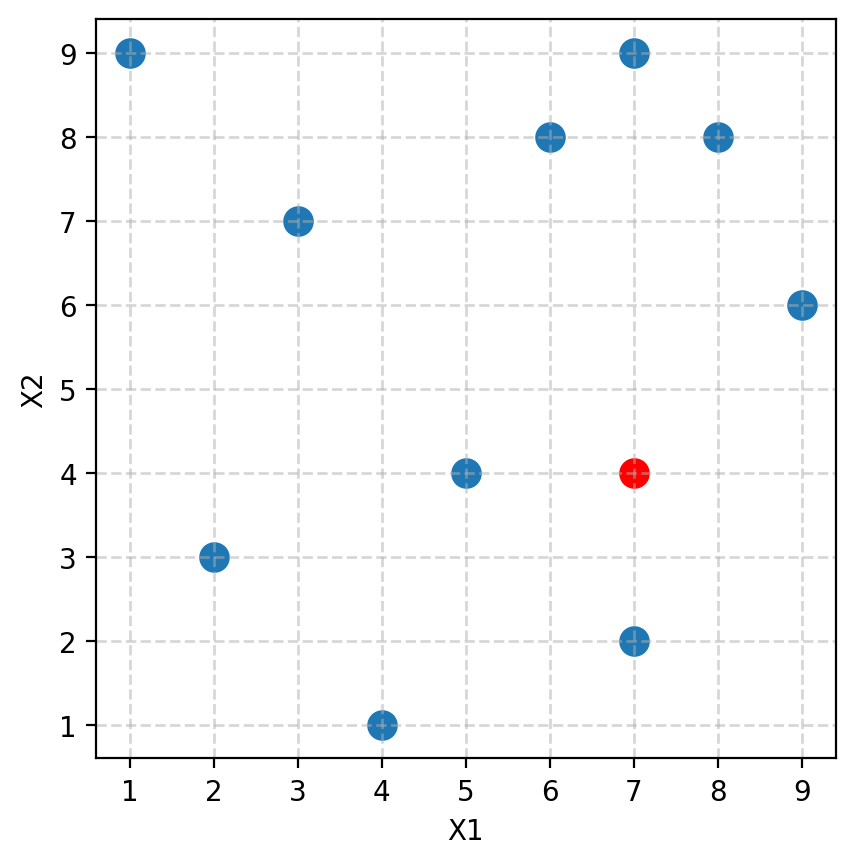

In [65]:
X = np.array([[1, 9], [2, 3], [4, 1], [3, 7], [5, 4], [6, 8], [7, 2], [8, 8], [7, 9], [9, 6]])

query_pt = np.array([7, 4])
a
def plot_dataset():
    plt.scatter(X[:, 0], X[:, 1], s=100)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=0.5)
    plt.xticks(np.arange(min(X[:, 0]), max(X[:, 0])+1, 1))
    plt.yticks(np.arange(min(X[:, 1]), max(X[:, 1])+1, 1))
    
    plt.scatter(query_pt[0], query_pt[1], color='red', s=100)
    

plot_dataset()




In [66]:
# Exact 1NN from sklearn
from sklearn.neighbors import NearestNeighbors

k = 2
nbrs = NearestNeighbors(n_neighbors=k, algorithm='brute').fit(X)
distances, indices = nbrs.kneighbors([query_pt])

In [27]:

X[indices], distances

(array([[[5, 4],
         [7, 2]]]),
 array([[2., 2.]]))

In [28]:
def pairwise_dist_naive(x: np.ndarray, y: np.ndarray) -> float:
    """
    x: numpy array of shape (d,)
    y: numpy array of shape (d,)
    
    Returns the Euclidean distance between x and y
    """
    d = len(x)
    assert d == len(y)
    sqrd_distance = 0.0
    for i in range(d):
        sqrd_distance += (x[i] - y[i])**2
    return np.sqrt(sqrd_distance)

In [29]:
def pairwise_dist_numpy(x: np.ndarray, y: np.ndarray) -> float:
    """
    x: numpy array of shape (d,)
    y: numpy array of shape (d,)
    
    Returns the Euclidean distance between x and y
    """
    return np.sqrt(np.sum((x - y)**2))

In [30]:
def pairwise_dist_numpy_norm(x: np.ndarray, y: np.ndarray) -> float:
    """
    x: numpy array of shape (d,)
    y: numpy array of shape (d,)
    
    Returns the Euclidean distance between x and y
    """
    return np.linalg.norm(x - y)

In [31]:
pairwise_dist_naive(X[0], X[1]), pairwise_dist_numpy(X[0], X[1]), pairwise_dist_numpy_norm(X[0], X[1])

(6.082762530298219, 6.082762530298219, 6.082762530298219)

In [35]:
def distance_vector(X: np.ndarray, query_pt: np.ndarray) -> np.ndarray:
    """
    X: numpy array of shape (n, d)
    query_pt: numpy array of shape (d,)
    
    Returns the Euclidean distance between query_pt and each point in X
    """
    n, d = X.shape
    distances = np.zeros(n)
    """Write logic here"""
    
    return distances

In [ ]:
# Test that the function is correct by comparing to sklearn

In [39]:
# Find all distances from query_pt to all points in X using sklearn
nbrs = NearestNeighbors(n_neighbors=len(X), algorithm='brute').fit(X)
distances_sklearn, idxs_sklearn = nbrs.kneighbors([query_pt])
print(distances_sklearn)

[[2.         2.         2.82842712 4.12310563 4.12310563 4.24264069
  5.         5.         5.09901951 7.81024968]]


In [47]:
distances_sklearn[0, idxs_sklearn[0]]

array([4.12310563, 5.        , 7.81024968, 4.24264069, 5.        ,
       2.82842712, 4.12310563, 5.09901951, 2.        , 2.        ])

In [48]:
import pandas as pd

df = pd.DataFrame(X, columns=['X1', 'X2'])
df["query_distance"] = distances_sklearn[0, idxs_sklearn[0]]
df

,X1,X2,query_distance
0,1,9,4.123106
1,2,3,5.000000
2,4,1,7.810250
3,3,7,4.242641
4,5,4,5.000000
5,6,8,2.828427
6,7,2,4.123106
7,8,8,5.099020
8,7,9,2.000000
9,9,6,2.000000


In [49]:
### LSH with Random Projections



In [181]:
### Random Projections

P = 3
np.random.seed(35)
R = np.random.randn(X.shape[1] + 1, P)  # why +1?

In [182]:
R

array([[-1.88973671, -0.41359218, -0.76602601],
       [-0.92412667, -1.42159783,  0.80525599],
       [ 1.14886176,  1.1694284 , -0.80200928]])

In [183]:
# For now, make R[:, 2] =1 to make it easier to plot
R[:, 2] = 1
R

array([[-1.88973671, -0.41359218,  1.        ],
       [-0.92412667, -1.42159783,  1.        ],
       [ 1.14886176,  1.1694284 ,  1.        ]])

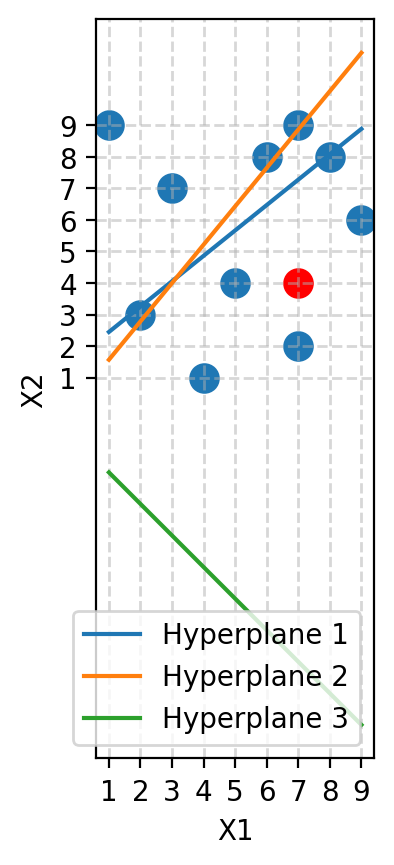

In [184]:
plot_dataset()

# Plot hyperplanes
for i in range(P):
    x1 = np.array([min(X[:, 0]), max(X[:, 0])])
    x2 = (-R[0, i] - R[1, i]*x1) / R[2, i]
    plt.plot(x1, x2, label=f'Hyperplane {i+1}')
plt.legend()

In [185]:
X_aug = np.hstack([ np.ones((X.shape[0], 1)), X])
X_aug

array([[1., 1., 9.],
       [1., 2., 3.],
       [1., 4., 1.],
       [1., 3., 7.],
       [1., 5., 4.],
       [1., 6., 8.],
       [1., 7., 2.],
       [1., 8., 8.],
       [1., 7., 9.],
       [1., 9., 6.]])

In [186]:
X_aug @ R

array([[ 7.52589247,  8.68966556, 11.        ],
       [-0.29140476,  0.25149734,  6.        ],
       [-4.43738162, -4.93055512,  6.        ],
       [ 3.37991562,  3.5076131 , 11.        ],
       [-1.914923  , -2.84386777, 10.        ],
       [ 1.75639738,  0.41224799, 15.        ],
       [-6.06089985, -8.02592023, 10.        ],
       [-0.09185596, -2.43094768, 17.        ],
       [ 1.98113247,  0.16007855, 17.        ],
       [-3.31370614, -6.19140231, 16.        ]])

In [187]:
np.sign(X_aug @ R)

array([[ 1.,  1.,  1.],
       [-1.,  1.,  1.],
       [-1., -1.,  1.],
       [ 1.,  1.,  1.],
       [-1., -1.,  1.],
       [ 1.,  1.,  1.],
       [-1., -1.,  1.],
       [-1., -1.,  1.],
       [ 1.,  1.,  1.],
       [-1., -1.,  1.]])